# NB08: TPE Optimization Analysis

**Question:** How did the TPE optimizer explore the search space? Did it converge?

This notebook analyzes Optuna's TPE sampling behavior:
1. **Convergence curves** — F1 vs trial number
2. **Parameter importance** — TPE's learned importance vs variance decomposition
3. **Exploration heatmaps** — which regions got most trials
4. **Best trial per model** — did TPE converge on the same recipe?

In [1]:
print(1)

1


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats

from analysis_utils import (
    load_all_results, setup_plotting, identify_bottlenecks,
    PRIMARY_METRIC, BROKEN_MODELS, MODEL_TIER, MODEL_PARAMS,
)

setup_plotting()
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

# Check for Optuna study database
optuna_db = STUDY_PATH / "optuna_study.db"
has_optuna = optuna_db.exists()
print(f"Optuna DB found: {has_optuna}")
if has_optuna:
    print(f"  Path: {optuna_db}")
    print(f"  Size: {optuna_db.stat().st_size / 1024 / 1024:.1f} MB")

Optuna DB found: True
  Path: ../outputs/smart_retrieval_slm/optuna_study.db
  Size: 1.6 MB


In [3]:
study = None
trials_df = pd.DataFrame()

if has_optuna:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    storage = f"sqlite:///{optuna_db}"
    study_summaries = optuna.study.get_all_study_summaries(storage)
    print(f"Studies in DB: {len(study_summaries)}")
    for s in study_summaries:
        print(f"  {s.study_name}: {s.n_trials} trials, "
              f"best={s.best_trial.value if s.best_trial else 'N/A'}")

    # Load the main study (first one, or the one with most trials)
    best_summary = max(study_summaries, key=lambda s: s.n_trials)
    study = optuna.load_study(study_name=best_summary.study_name, storage=storage)
    trials_df = study.trials_dataframe()
    print(f"\nLoaded study: {study.study_name}")
    print(f"  Trials: {len(trials_df)}")
    print(f"  Params: {list(trials_df.filter(like='params_').columns)}")
else:
    print("No Optuna DB — using experiment results as proxy for optimization analysis.")
    df_all = load_all_results(STUDY_PATH)
    df = df_all[~df_all['model_short'].isin(BROKEN_MODELS)].copy()

Studies in DB: 1
  smart_retrieval_slm_tpe: 751 trials, best=0.6777492900563489

Loaded study: smart_retrieval_slm_tpe
  Trials: 751
  Params: ['params_agent_type', 'params_alpha', 'params_dataset', 'params_fallback_to_direct', 'params_max_iterations', 'params_model', 'params_prompt', 'params_query_transform', 'params_reranker', 'params_retrieval_threshold', 'params_retriever', 'params_rrf_k', 'params_stop_on_sufficient', 'params_top_k', 'params_verify_answer']


## 1. Convergence Curves

Note: Trials span 3 datasets — normalizing F1 within each dataset (z-score).


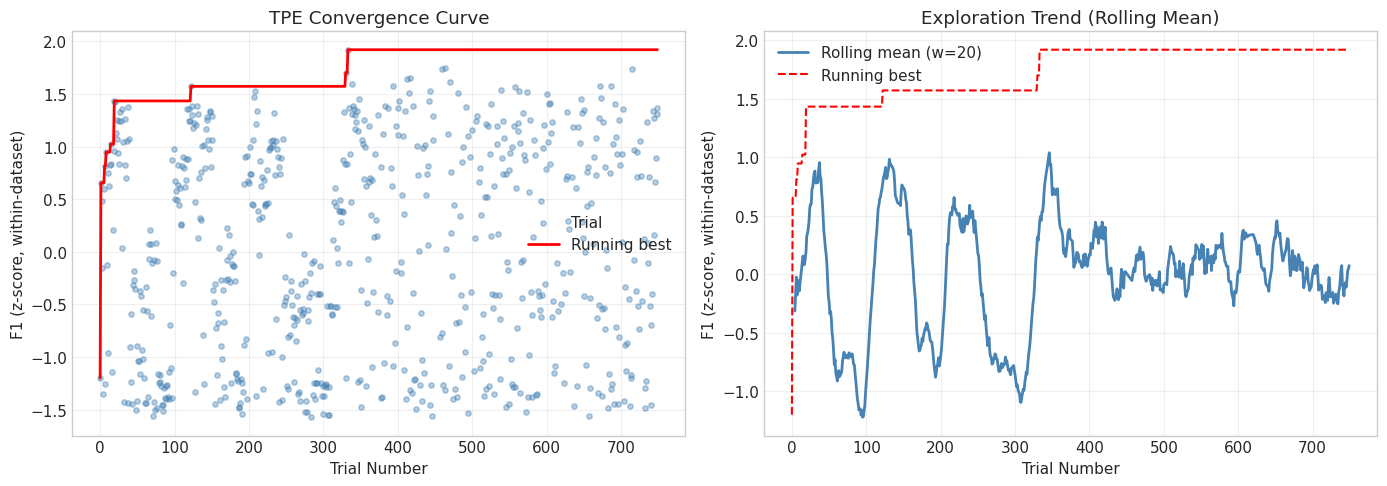


Convergence check:
  Best in first 75% of trials: 1.9212
  Best in last 25% of trials:  1.7411
  Improvement: -0.1801
  -> Study appears converged


In [4]:
if not trials_df.empty:
    completed = trials_df[trials_df['state'] == 'COMPLETE'].copy()
    completed = completed.sort_values('number')

    # Check if trials span multiple datasets — if so, normalize F1 within each dataset
    dataset_col = next((c for c in completed.columns
                        if 'dataset' in c.lower() and 'params' in c.lower()), None)

    if dataset_col and completed[dataset_col].nunique() > 1:
        # Normalize F1 within each dataset (z-score) to make cross-dataset trials comparable
        print(f"Note: Trials span {completed[dataset_col].nunique()} datasets — "
              f"normalizing F1 within each dataset (z-score).")
        completed['value_raw'] = completed['value']
        completed['value'] = completed.groupby(dataset_col)['value'].transform(
            lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
        )
        ylabel = 'F1 (z-score, within-dataset)'
    else:
        ylabel = 'F1'

    completed['running_best'] = completed['value'].cummax()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # All trials scatter
    axes[0].scatter(completed['number'], completed['value'],
                    s=15, alpha=0.4, color='steelblue', label='Trial')
    axes[0].plot(completed['number'], completed['running_best'],
                 color='red', linewidth=2, label='Running best')
    axes[0].set_xlabel('Trial Number')
    axes[0].set_ylabel(ylabel)
    axes[0].set_title('TPE Convergence Curve')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Rolling mean (window=20)
    if len(completed) >= 20:
        rolling = completed['value'].rolling(window=20, min_periods=5).mean()
        axes[1].plot(completed['number'], rolling, color='steelblue',
                     linewidth=2, label='Rolling mean (w=20)')
        axes[1].plot(completed['number'], completed['running_best'],
                     color='red', linewidth=1.5, linestyle='--', label='Running best')
        axes[1].set_xlabel('Trial Number')
        axes[1].set_ylabel(ylabel)
        axes[1].set_title('Exploration Trend (Rolling Mean)')
        axes[1].legend()
        axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Convergence check: improvement in last 25%
    n = len(completed)
    q3_start = n * 3 // 4
    best_first_75 = completed.iloc[:q3_start]['value'].max()
    best_last_25 = completed.iloc[q3_start:]['value'].max()
    print(f"\nConvergence check:")
    print(f"  Best in first 75% of trials: {best_first_75:.4f}")
    print(f"  Best in last 25% of trials:  {best_last_25:.4f}")
    print(f"  Improvement: {best_last_25 - best_first_75:+.4f}")
    if best_last_25 - best_first_75 < 0.005:
        print("  -> Study appears converged")
    else:
        print("  -> Study was still improving")
else:
    print("No Optuna trials data. Skipping convergence analysis.")

### 1b. Per-Model Convergence

Did TPE converge on every model subspace, or are some models under-explored?
This matters for thesis claims: if TPE only ran 20 trials on a model,
the "best config" is less reliable than one found after 200 trials.

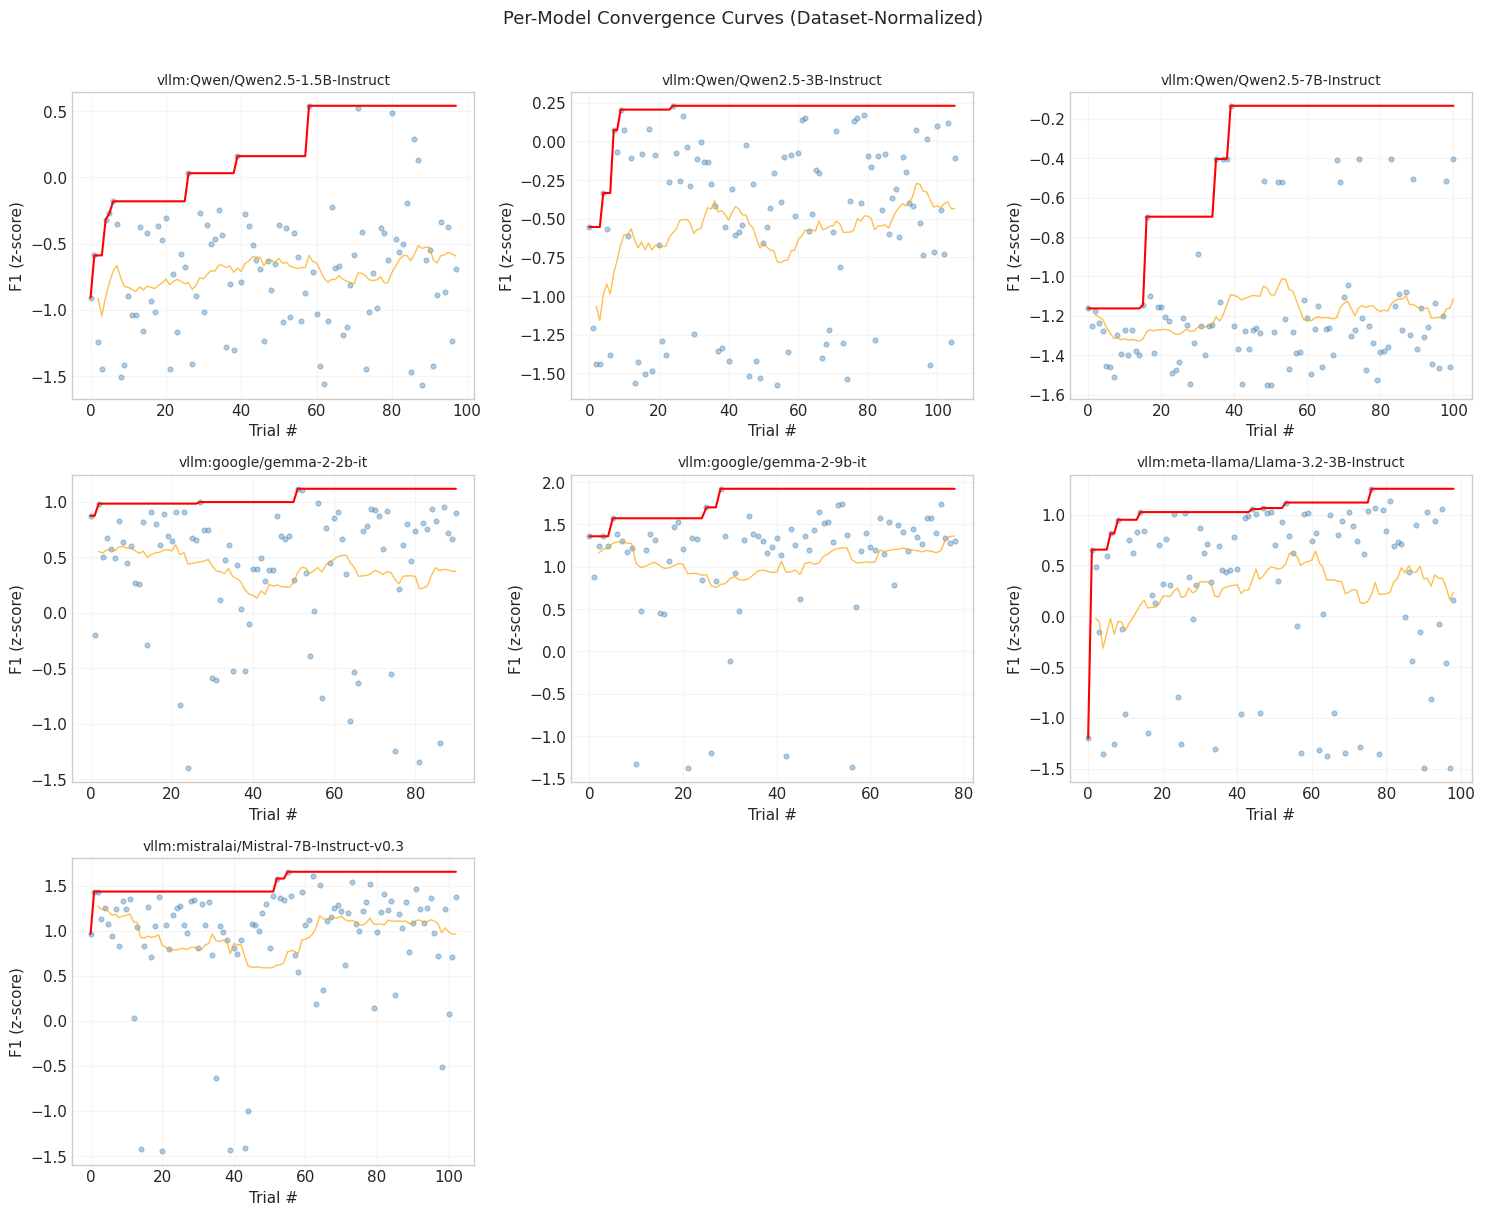


Per-Model Convergence Assessment:


,model,n_trials,best_f1,mean_f1,std_f1,improvement,converged
0,vllm:Qwen/Qwen2.5-1.5B-Instruct,98,0.5416,-0.7040,0.4718,-0.0576,Yes
1,vllm:Qwen/Qwen2.5-3B-Instruct,106,0.2297,-0.5418,0.5566,-0.0600,Yes
2,vllm:Qwen/Qwen2.5-7B-Instruct,101,-0.1346,-1.1747,0.3310,-0.2696,Yes
3,vllm:google/gemma-2-2b-it,91,1.1150,0.3875,0.6129,-0.1683,Yes
4,vllm:google/gemma-2-9b-it,79,1.9212,1.0936,0.7126,-0.1801,Yes
5,vllm:meta-llama/Llama-3.2-3B-Instruct,99,1.2532,0.2750,0.8309,0.1352,No
6,vllm:mistralai/Mistral-7B-Instruct-v0.3,103,1.6540,0.9339,0.6518,-0.1317,Yes



Overall: 6 converged, 1 still improving, 0 insufficient trials


In [5]:
# Per-model convergence: did TPE converge on each model subspace?
convergence_rows = []

if not trials_df.empty:
    completed = trials_df[trials_df['state'] == 'COMPLETE'].copy()
    model_col = next((c for c in completed.columns
                      if 'model' in c.lower() and 'params' in c.lower()), None)

    # Check for dataset column — normalize if multi-dataset
    dataset_col = next((c for c in completed.columns
                        if 'dataset' in c.lower() and 'params' in c.lower()), None)

    if dataset_col and completed[dataset_col].nunique() > 1:
        completed['value_raw'] = completed['value']
        completed['value'] = completed.groupby(dataset_col)['value'].transform(
            lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
        )
        ylabel = 'F1 (z-score)'
    else:
        ylabel = 'F1'

    if model_col:
        models = sorted(completed[model_col].unique())
        n_models = len(models)
        ncols = min(3, n_models)
        nrows = (n_models + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
        axes_flat = np.atleast_1d(axes).flatten()

        for idx, model in enumerate(models):
            m_trials = completed[completed[model_col] == model].sort_values('number').copy()
            m_trials['local_trial'] = range(len(m_trials))
            m_trials['running_best'] = m_trials['value'].cummax()

            ax = axes_flat[idx]
            ax.scatter(m_trials['local_trial'], m_trials['value'],
                       s=12, alpha=0.4, color='steelblue')
            ax.plot(m_trials['local_trial'], m_trials['running_best'],
                    color='red', linewidth=1.5)

            if len(m_trials) >= 10:
                w = min(20, len(m_trials) // 3)
                rolling = m_trials['value'].rolling(window=w, min_periods=3).mean()
                ax.plot(m_trials['local_trial'], rolling,
                        color='orange', linewidth=1, alpha=0.7)

            ax.set_title(model, fontsize=10)
            ax.set_xlabel('Trial #')
            ax.set_ylabel(ylabel)
            ax.grid(alpha=0.2)

            n = len(m_trials)
            if n >= 8:
                q3 = n * 3 // 4
                best_75 = m_trials.iloc[:q3]['value'].max()
                best_25 = m_trials.iloc[q3:]['value'].max()
                improvement = best_25 - best_75
                converged = improvement < 0.005
            else:
                best_75 = np.nan
                best_25 = np.nan
                improvement = np.nan
                converged = None

            convergence_rows.append({
                'model': model,
                'n_trials': n,
                'best_f1': m_trials['value'].max(),
                'mean_f1': m_trials['value'].mean(),
                'std_f1': m_trials['value'].std(),
                'best_first_75pct': best_75,
                'best_last_25pct': best_25,
                'improvement': improvement,
                'converged': converged,
            })

        for idx in range(n_models, len(axes_flat)):
            axes_flat[idx].set_visible(False)

        plt.suptitle('Per-Model Convergence Curves (Dataset-Normalized)', y=1.01, fontsize=13)
        plt.tight_layout()
        plt.show()

else:
    # Fallback: use experiment results — stratify by dataset
    if 'df' in dir() and not df.empty:
        rag = df[df['exp_type'] == 'rag'].copy()
        for model in sorted(rag['model_short'].unique()):
            m_df = rag[rag['model_short'] == model].sort_values('name')
            n = len(m_df)
            # Stratified: per-(model, dataset) stats, then average
            per_ds = m_df.groupby('dataset')[PRIMARY_METRIC].agg(['max', 'mean', 'std', 'count'])
            if per_ds['count'].sum() < 3:
                continue
            convergence_rows.append({
                'model': model,
                'n_trials': n,
                'best_f1': per_ds['max'].mean(),  # avg of per-dataset best
                'mean_f1': per_ds['mean'].mean(),  # avg of per-dataset mean
                'std_f1': per_ds['std'].mean() if per_ds['std'].notna().any() else np.nan,
                'best_first_75pct': np.nan,
                'best_last_25pct': np.nan,
                'improvement': np.nan,
                'converged': None,
            })

# Convergence summary table
if convergence_rows:
    conv_df = pd.DataFrame(convergence_rows)
    conv_df['improvement'] = conv_df['best_last_25pct'] - conv_df['best_first_75pct']
    conv_df['converged'] = conv_df['improvement'].apply(
        lambda x: 'Yes' if pd.notna(x) and x < 0.005
        else ('No' if pd.notna(x) else 'Too few trials')
    )

    print("\nPer-Model Convergence Assessment:")
    print("=" * 80)
    display(conv_df[['model', 'n_trials', 'best_f1', 'mean_f1', 'std_f1',
                     'improvement', 'converged']].round(4))

    median_trials = conv_df['n_trials'].median()
    under_explored = conv_df[conv_df['n_trials'] < median_trials * 0.5]
    if not under_explored.empty:
        print(f"\nUnder-explored models (< {median_trials * 0.5:.0f} trials, "
              f"half the median of {median_trials:.0f}):")
        for _, row in under_explored.iterrows():
            print(f"  {row['model']}: only {row['n_trials']} trials "
                  f"(best F1={row['best_f1']:.4f})")

    n_converged = (conv_df['converged'] == 'Yes').sum()
    n_not = (conv_df['converged'] == 'No').sum()
    n_few = (conv_df['converged'] == 'Too few trials').sum()
    print(f"\nOverall: {n_converged} converged, {n_not} still improving, "
          f"{n_few} insufficient trials")

## 2. Parameter Importance

Compare TPE's learned parameter importance with the variance decomposition from NB03.

TPE Parameter Importance:
  dataset                  : 0.419 ####################
  model                    : 0.406 ####################
  prompt                   : 0.141 #######
  retriever                : 0.018 
  agent_type               : 0.008 
  top_k                    : 0.003 
  reranker                 : 0.003 
  query_transform          : 0.002 

  343 experiment(s) use configs outside the current YAML.
  Consider adding these to your study config to explore them:
    • model: 42 exps — Phi-3-mini
    • query_transform: 314 exps — iterative
  Deduplicated: dropped 241 duplicate experiments (same effective config, kept best F1)


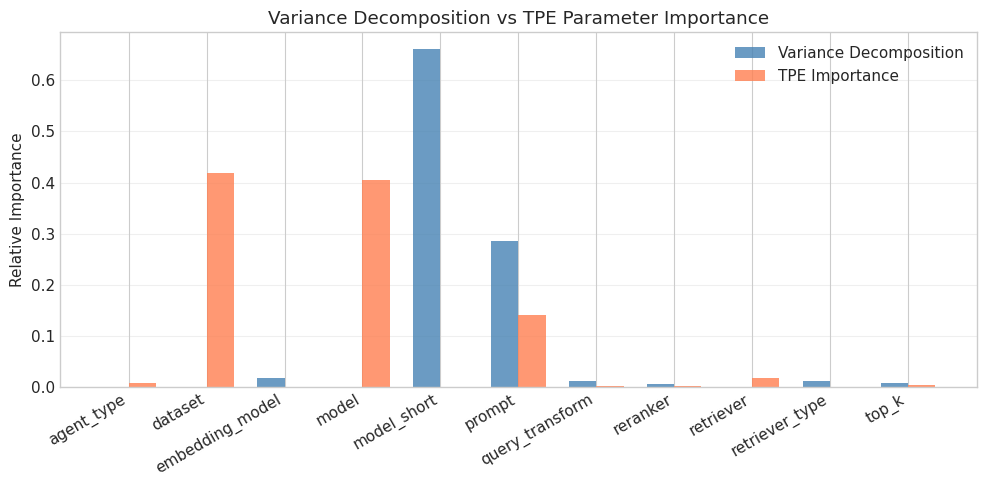

In [6]:
tpe_importance = {}
if study is not None:
    try:
        from optuna.importance import get_param_importances
        tpe_importance = get_param_importances(study)
        print("TPE Parameter Importance:")
        for param, imp in sorted(tpe_importance.items(), key=lambda x: -x[1]):
            bar = '#' * int(imp * 50)
            print(f"  {param:<25s}: {imp:.3f} {bar}")
    except Exception as e:
        print(f"Could not compute importance: {e}")

# Compare with variance decomposition
if not trials_df.empty or 'df' in dir():
    source_df = df if 'df' in dir() else load_all_results(STUDY_PATH)
    source_df = source_df[~source_df['model_short'].isin(BROKEN_MODELS)]
    variance_decomp = identify_bottlenecks(source_df, PRIMARY_METRIC)

    if tpe_importance and variance_decomp:
        # Normalize variance decomp to sum to 1 for comparison
        total_var = sum(variance_decomp.values())
        var_norm = {k: v / total_var for k, v in variance_decomp.items()} if total_var > 0 else {}

        # Map TPE param names to variance decomp names
        param_map = {
            'params_retriever': 'retriever_type',
            'params_top_k': 'top_k',
            'params_prompt': 'prompt',
            'params_query_transform': 'query_transform',
            'params_reranker': 'reranker',
            'params_agent_type': 'agent_type',
            'params_model': 'model_short',
        }

        all_factors = set()
        all_factors.update(var_norm.keys())
        all_factors.update(param_map.get(k, k) for k in tpe_importance.keys())
        all_factors = sorted(all_factors)

        fig, ax = plt.subplots(figsize=(10, 5))
        x = np.arange(len(all_factors))
        w = 0.35
        var_vals = [var_norm.get(f, 0) for f in all_factors]
        tpe_vals = [tpe_importance.get(f'params_{f}', tpe_importance.get(f, 0))
                    for f in all_factors]

        ax.bar(x - w/2, var_vals, w, label='Variance Decomposition', color='steelblue', alpha=0.8)
        ax.bar(x + w/2, tpe_vals, w, label='TPE Importance', color='coral', alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(all_factors, rotation=30, ha='right')
        ax.set_ylabel('Relative Importance')
        ax.set_title('Variance Decomposition vs TPE Parameter Importance')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    elif variance_decomp:
        print("\nVariance decomposition (no TPE data to compare):")
        for f, v in variance_decomp.items():
            print(f"  {f:<20s}: {v:.1f}%")

## 3. Exploration Heatmaps

Which parameter combinations did TPE explore most heavily?

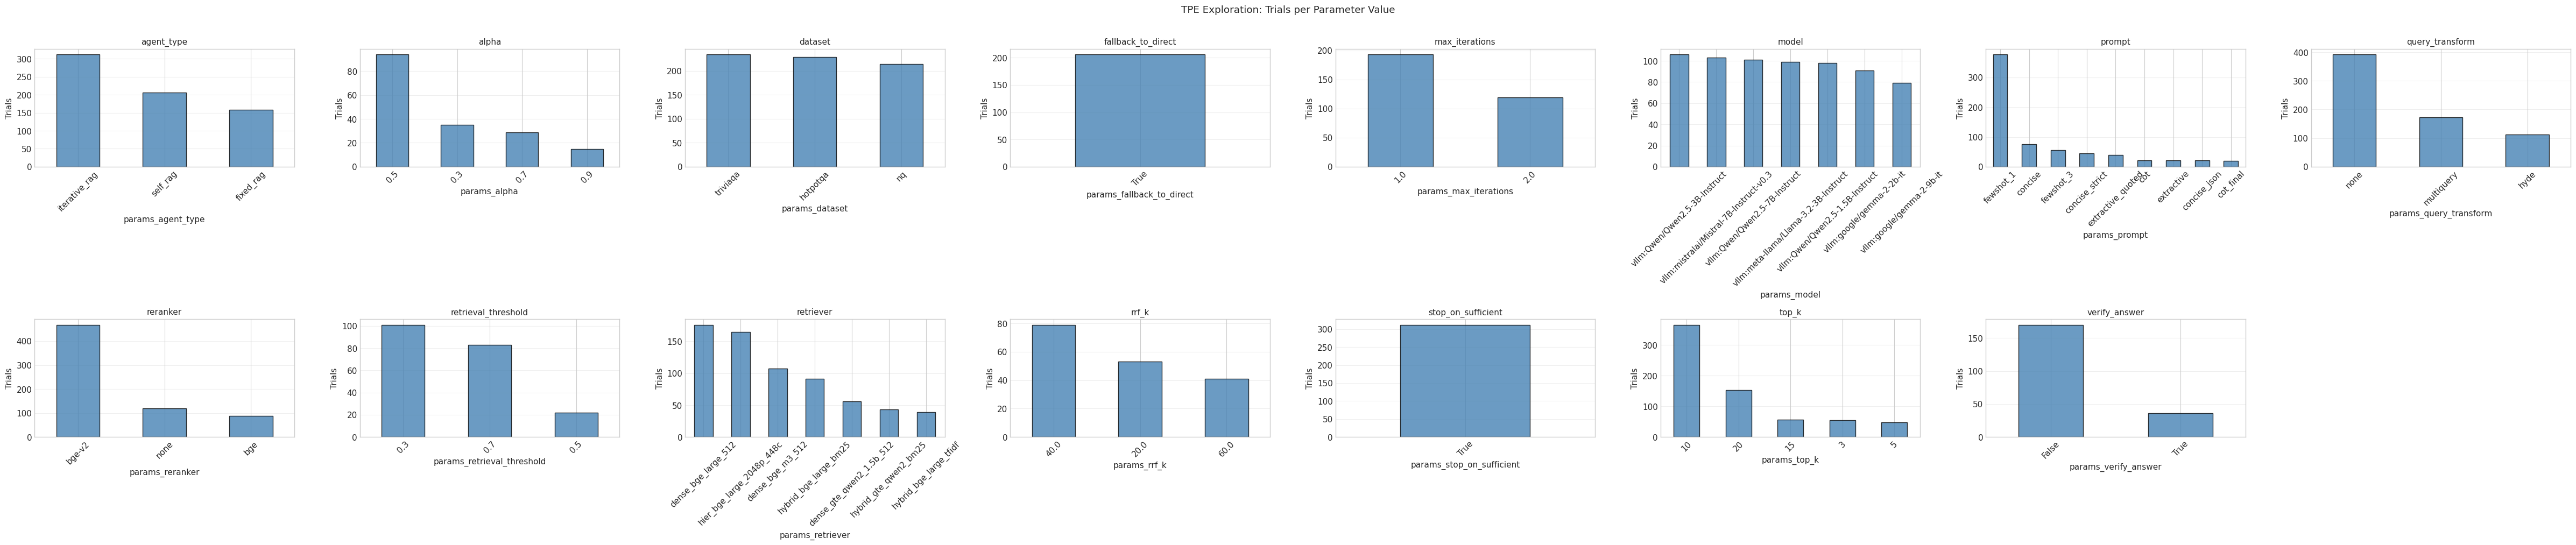

In [7]:
if not trials_df.empty:
    param_cols = [c for c in trials_df.columns if c.startswith('params_')]

    # Count how many trials explored each value of each parameter
    fig, axes = plt.subplots(2, (len(param_cols) + 1) // 2,
                             figsize=(6 * ((len(param_cols) + 1) // 2), 10))
    axes_flat = axes.flatten()

    for idx, col in enumerate(param_cols):
        if idx >= len(axes_flat):
            break
        ax = axes_flat[idx]
        completed = trials_df[trials_df['state'] == 'COMPLETE']
        counts = completed[col].value_counts()
        counts.plot(kind='bar', ax=ax, color='steelblue', alpha=0.8, edgecolor='black')
        ax.set_title(col.replace('params_', ''), fontsize=11)
        ax.set_ylabel('Trials')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)

    for idx in range(len(param_cols), len(axes_flat)):
        axes_flat[idx].set_visible(False)

    plt.suptitle('TPE Exploration: Trials per Parameter Value', y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("No trial data for exploration analysis.")

In [8]:
# 2D exploration heatmap: top 2 most important parameters
if not trials_df.empty and len(param_cols) >= 2:
    # Pick top-2 by TPE importance, or just first 2 categorical params
    if tpe_importance:
        top_params = sorted(tpe_importance.keys(), key=lambda k: -tpe_importance[k])[:2]
    else:
        top_params = param_cols[:2]

    # Ensure they exist
    top_params = [p if p in trials_df.columns else p.replace('params_', '')
                  for p in top_params]
    top_params = [p for p in top_params if p in trials_df.columns][:2]

    if len(top_params) == 2:
        completed = trials_df[trials_df['state'] == 'COMPLETE']

        # Check for dataset column — stratify mean F1 heatmap
        dataset_col = next((c for c in completed.columns
                            if 'dataset' in c.lower() and 'params' in c.lower()), None)

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Count heatmap (not affected by stratification)
        count_pivot = pd.crosstab(completed[top_params[0]], completed[top_params[1]])
        sns.heatmap(count_pivot, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title(f'Exploration Density: {top_params[0]} x {top_params[1]}')

        # Mean F1 heatmap — stratified by dataset if available
        if dataset_col and completed[dataset_col].nunique() > 1:
            # Per-(p1, p2, dataset) mean, then average across datasets
            strat_mean = (
                completed.groupby([top_params[0], top_params[1], dataset_col])['value']
                .mean()
                .groupby([top_params[0], top_params[1]]).mean()
                .unstack(top_params[1])
            )
            sns.heatmap(strat_mean, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1])
            axes[1].set_title(f'Mean F1 (dataset-stratified): {top_params[0]} x {top_params[1]}')
        else:
            mean_pivot = completed.pivot_table(
                index=top_params[0], columns=top_params[1],
                values='value', aggfunc='mean'
            )
            sns.heatmap(mean_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1])
            axes[1].set_title(f'Mean F1: {top_params[0]} x {top_params[1]}')

        plt.tight_layout()
        plt.show()

## 4. Best Trial per Model

Did TPE find the same "optimal recipe" across different models, or does each model need different settings?

In [9]:
if not trials_df.empty:
    completed = trials_df[trials_df['state'] == 'COMPLETE'].copy()

    model_col = next((c for c in completed.columns if 'model' in c.lower() and 'params' in c.lower()), None)
    dataset_col = next((c for c in completed.columns
                        if 'dataset' in c.lower() and 'params' in c.lower()), None)

    if model_col:
        # Best trial per (model, dataset) then show table
        if dataset_col and completed[dataset_col].nunique() > 1:
            print("Best Configuration per Model x Dataset (from TPE):")
            print("=" * 70)
            best_per_md = completed.loc[
                completed.groupby([model_col, dataset_col])['value'].idxmax()
            ]
            for _, row in best_per_md.sort_values([model_col, dataset_col]).iterrows():
                print(f"\n  {row[model_col]} / {row[dataset_col]} "
                      f"(F1={row['value']:.4f}, trial #{row['number']}):")
                for col in param_cols:
                    if col not in (model_col, dataset_col):
                        print(f"    {col.replace('params_', ''):<20s}: {row[col]}")

            # Recipe agreement: check across models AND datasets
            non_key_params = [c for c in param_cols if c not in (model_col, dataset_col)]
            print("\n\nRecipe Agreement Across Models x Datasets:")
            for col in non_key_params:
                values = best_per_md[col].dropna().unique()
                if len(values) == 1:
                    print(f"  {col.replace('params_', ''):<20s}: UNANIMOUS — {values[0]}")
                else:
                    mode = best_per_md[col].mode().iloc[0]
                    agreement = (best_per_md[col] == mode).mean() * 100
                    print(f"  {col.replace('params_', ''):<20s}: VARIES — mode={mode} ({agreement:.0f}% agree)")
        else:
            # Single dataset or no dataset column — original behavior
            best_per_model = completed.loc[completed.groupby(model_col)['value'].idxmax()]
            print("Best Configuration per Model (from TPE):")
            print("=" * 60)
            for _, row in best_per_model.iterrows():
                print(f"\n  {row[model_col]} (F1={row['value']:.4f}, trial #{row['number']}):")
                for col in param_cols:
                    if col != model_col:
                        print(f"    {col.replace('params_', ''):<20s}: {row[col]}")

            non_model_params = [c for c in param_cols if c != model_col]
            print("\n\nRecipe Agreement Across Models:")
            for col in non_model_params:
                values = best_per_model[col].dropna().unique()
                if len(values) == 1:
                    print(f"  {col.replace('params_', ''):<20s}: UNANIMOUS — {values[0]}")
                else:
                    mode = best_per_model[col].mode().iloc[0]
                    agreement = (best_per_model[col] == mode).mean() * 100
                    print(f"  {col.replace('params_', ''):<20s}: VARIES — mode={mode} ({agreement:.0f}% agree)")
    else:
        print("No model parameter found in trial data.")
else:
    # Fallback: use experiment results — stratified by dataset
    if 'df' in dir() and not df.empty:
        rag = df[df['exp_type'] == 'rag']
        config_cols = ['retriever_type', 'embedding_model', 'reranker', 'prompt',
                       'query_transform', 'top_k', 'agent_type']
        config_cols = [c for c in config_cols if c in rag.columns]

        print("Best Configuration per Model x Dataset (from experiment results):")
        print("=" * 70)
        for model in sorted(rag['model_short'].unique()):
            for ds in sorted(rag['dataset'].unique()):
                m_df = rag[(rag['model_short'] == model) & (rag['dataset'] == ds)]
                if m_df[PRIMARY_METRIC].notna().sum() == 0:
                    continue
                best_idx = m_df[PRIMARY_METRIC].idxmax()
                best = m_df.loc[best_idx]
                print(f"\n  {model} / {ds} (F1={best[PRIMARY_METRIC]:.4f}):")
                for c in config_cols:
                    print(f"    {c:<20s}: {best.get(c, 'N/A')}")

Best Configuration per Model x Dataset (from TPE):

  vllm:Qwen/Qwen2.5-1.5B-Instruct / hotpotqa (F1=0.1988, trial #406):
    agent_type          : iterative_rag
    alpha               : 0.5
    fallback_to_direct  : nan
    max_iterations      : 1.0
    prompt              : concise_strict
    query_transform     : hyde
    reranker            : bge-v2
    retrieval_threshold : nan
    retriever           : hybrid_gte_qwen2_bm25
    rrf_k               : 40.0
    stop_on_sufficient  : True
    top_k               : 10
    verify_answer       : nan

  vllm:Qwen/Qwen2.5-1.5B-Instruct / nq (F1=0.2140, trial #160):
    agent_type          : fixed_rag
    alpha               : 0.7
    fallback_to_direct  : nan
    max_iterations      : nan
    prompt              : concise_json
    query_transform     : multiquery
    reranker            : bge-v2
    retrieval_threshold : nan
    retriever           : hybrid_bge_large_bm25
    rrf_k               : 40.0
    stop_on_sufficient  : nan
    t

## 5. Summary

Key findings:
- Whether TPE converged or was still exploring
- Agreement between TPE importance and variance decomposition
- Which search space regions were over/under-explored
- Whether an optimal "universal recipe" exists or configs are model-specific